# Plan




1. Get gradients on transition matrix for n-steps
2. Figure out what to multiply a vector by to obtain skew-symmetric matrix - [x] 
    -1. A~
3. Use caley transform to generate a unitary matrix - [x] 
4. Run whole thing through jax to get PI representation

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy.optimize as op
from functools import partial
seaborn.set(font_scale=1.5,style='ticks')

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Run with jax

In [2]:
dim = 4
nT = 9
x0 = np.random.normal(size=(dim,1))
A_ = np.random.normal(size=(dim,dim))

A = np.zeros([dim,dim])

for i in range(dim):
    A[i,i:] = A_[i:,i]
    A[i:,i] = -A_[i:,i]
    
A[np.diag_indices_from(A)] = 0
A = (np.eye(dim)-A)@np.linalg.inv(np.eye(dim)+A)

x = np.array([np.linalg.matrix_power(A,i)@x0 for i in range(9)])

In [3]:
#plt.plot(x[:,1])
#plt.yscale('symlog')

In [4]:
Ahat = np.random.normal(size=(dim,dim))


In [5]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random


In [6]:
def predict(Ahat,x,y,n,dim):
    Ahat = jnp.reshape(Ahat,(dim,dim))
    return jnp.sum((jnp.dot(jnp.linalg.matrix_power(Ahat,n),x)-y)**2)


predict_funs = [partial(predict,n=i,dim=dim) for i in range(9)]
grad_predict_funs = [grad(i) for i in predict_funs]

In [7]:
def get_basis_tensor(dim):
    """ Returns a tensor that forms a basis for skew symmetric matrices.
        Use np.einsum('i...,i...',params,basis_tensor) to construct this
        matrix
    """
    basis_tensor = []
    for i in range(dim):
        for j in range(i+1,dim):
            bi =  np.zeros([dim,dim])
            bi[i,j] = -1
            bi = bi -bi.T
            basis_tensor.append(bi.T)
    basis_tensor = np.array(basis_tensor)
    return np.asarray(basis_tensor)


In [8]:
basis_tensor = get_basis_tensor(dim)
n_bases = basis_tensor.shape[0]

In [9]:
v = np.abs(np.random.normal(size=(n_bases,1)))
skewM = np.einsum('i...,i...',v,basis_tensor)
M = construct_M(skewM,dim)

NameError: name 'construct_M' is not defined

In [10]:
M = construct_M(skewM,dim)

NameError: name 'construct_M' is not defined

In [11]:
np.linalg.norm(M,axis=0)

NameError: name 'M' is not defined

In [12]:
def construct_M(skewM,dim):
    """ Perform Caley transform"""
    return (np.eye(dim) - skewM)@np.linalg.inv(np.eye(dim)+skewM)

In [13]:
def predict_all(Ahat,x,predict_funs,grad_predict_funs,dim):
    Ahat = Ahat.reshape(dim,dim)
    #print(Ahat.shape)
    err = 0
    nT = len(x)
    k = 0
    for start_state in range(nT):
        for pred_state in range(start_state+1,nT-start_state):
            n_fwd = pred_state-start_state 
            err += predict_funs[n_fwd](Ahat,x[start_state],x[pred_state])
            k += 1
    return err/k


def predict_all_grad(Ahat,x,predict_funs,grad_predict_funs,dim):
    
    #n_ = len(Ahat.flatten())
    Ahat = Ahat.reshape(dim,dim)
    J = np.zeros(Ahat.shape)
    #print(J.shape)
    nT = len(x)
    k = 0
    for start_state in range(nT):
        for pred_state in range(start_state+1,nT):
            n_fwd =  pred_state-start_state 
            #print(n_fwd,J.shape,)
            #print(start_state,pred_state,n_fwd)
            J = J + grad_predict_funs[n_fwd](Ahat,x[start_state],x[pred_state])
            k+= 1
    #J = J/k
    return J.flatten()
    

In [14]:
predict_funs[1](A,x[0],x[1])

DeviceArray(3.608225e-15, dtype=float32)

In [15]:
dim*(dim-1)/2

6.0

In [16]:
#%%timeit
op.approx_fprime(Ahat.flatten(),
                 predict_all,
                 1e-4,
                 *(x,predict_funs,grad_predict_funs,dim)
            )

array([-893437.5,  578125. , -317812.5, -604062.5, 1031875. , -685000. ,
        341250. ,  708437.5,  223750. , -112500. ,  124062.5,  135000. ,
       -920937.5,  610312.5, -284687.5, -630000. ])

In [17]:
grad_predict_all = grad(predict_all)

In [18]:
#%%timeit
grad_predict_all(Ahat,x,predict_funs,grad_predict_funs,dim)

DeviceArray([[-894246.4  ,  578035.1  , -318542.62 , -604053.3  ],
             [1031996.25 , -684015.1  ,  340905.22 ,  707778.75 ],
             [ 224076.48 , -112426.305,  123453.09 ,  135018.52 ],
             [-921735.2  ,  610886.7  , -285240.62 , -629198.06 ]],            dtype=float32)

In [19]:
predict_all_grad(Ahat,x,predict_funs,grad_predict_funs,dim)

DeviceArray([-18157262. ,  12754362. ,  -7329935. , -12871900. ,
              21340716. , -15098608. ,   7379011. ,  14614595. ,
               4106253.5,  -2574106.5,   3415904.5,   3518732.5,
             -19265156. ,  13414134. ,  -5734985. , -12490897. ],            dtype=float32)

In [20]:
params = np.random.normal(size=(1,int(dim*(dim-1)/2)))# + np.eye(dim)
res = op.minimize(predict_all,
           params,
           (x,predict_funs,grad_predict_funs,dim),
           jac=grad_predict_all,
           method='Newton-CG'
           )
print(res.message)

ValueError: cannot reshape array of size 6 into shape (4,4)

In [21]:
res.message

NameError: name 'res' is not defined

In [22]:
Ainf = res.x.reshape(dim,dim)

NameError: name 'res' is not defined

NameError: name 'Ainf' is not defined

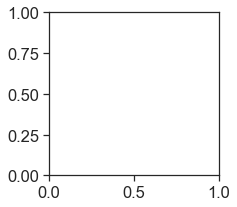

In [23]:
plt.figure(figsize=(14,3))

for i in range(dim):
    
    plt.subplot(1,dim,i+1)
    plt.plot((np.linalg.matrix_power(Ainf,1)@x)[:,i],marker='.')
    plt.plot((np.linalg.matrix_power(A,1)@x)[:,i],marker='.')
    #plt.

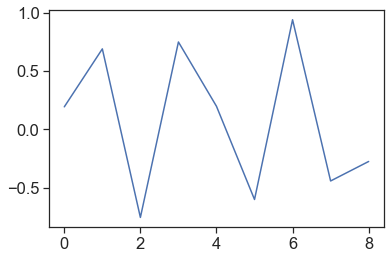

In [24]:
plt.plot((np.linalg.matrix_power(A,5)@x)[:,2])

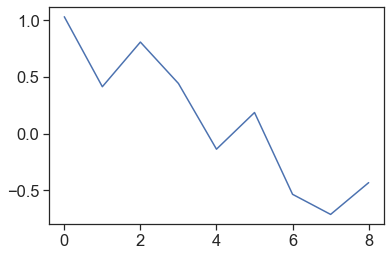

In [25]:
plt.plot(x[:,0])

In [423]:
a = np.random.normal(size=(5,1))
H = np.triu(np.ones([3,3,15]))

# Now do it properly with constraints

In [424]:
def get_basis_tensor(dim):
    """ Returns a tensor that forms a basis for skew symmetric matrices.
        Use np.einsum('i...,i...',params,basis_tensor) to construct this
        matrix
    """
    basis_tensor = []
    for i in range(dim):
        for j in range(i+1,dim):
            bi =  np.zeros([dim,dim])
            bi[i,j] = -1
            bi = bi -bi.T
            basis_tensor.append(bi.T)
    basis_tensor = np.array(basis_tensor)
    return np.asarray(basis_tensor)


In [425]:
def construct_M(skewM,dim):
    """ Perform Caley transform"""
    return (jnp.eye(dim) - skewM)@jnp.linalg.inv(jnp.eye(dim)+skewM)

In [426]:
params.shape

(3,)

In [427]:
def predict(T,x,y,n,dim):
    transition_matrix = jnp.reshape(T,(dim,dim))
    return jnp.sum((jnp.dot(jnp.linalg.matrix_power(transition_matrix,n),x)-y)**2)


#predict_funs = [partial(predict,n=i,dim=dim) for i in range(9)]
#grad_predict_funs = [grad(i) for i in predict_funs]

In [428]:
def predict_all(params,x,dim,basis_tensor):

    err = 0
    nT = len(x)
    k = 0
    skewM = jnp.einsum('i...,i...',params,basis_tensor)
    M = construct_M(skewM,dim)
    #print(M.shape)
    for start_state in range(nT):
        for pred_state in range(start_state+1,nT-start_state):
            n_fwd = pred_state-start_state 
            err += predict(M,x[start_state],x[pred_state],n_fwd,dim)
            k += 1
    mse = err/k
    print(mse)
    return mse


In [429]:
x.shape

(9, 3, 1)

In [430]:
A

array([[ 0.13774368, -0.32265073,  0.93644177],
       [ 0.86334433, -0.4242774 , -0.27317624],
       [ 0.4854516 ,  0.84609999,  0.22011715]])

In [431]:
predict_all(params,x,dim,basis_tensor)


15.750193


DeviceArray(15.750193, dtype=float32)

In [432]:
grad_predict_all = grad(predict_all)

In [433]:
a = grad_predict_all(jnp.array(res.x),x,dim,basis_tensor)

Traced<ConcreteArray(0.39445701241493225, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(0.394457, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7ff2747c2920>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7ff2748e42f0; to 'JaxprTracer' at 0x7ff2748e4110>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7ff2748c3730>)


In [434]:
a

DeviceArray([ 1.7732382e-06, -1.3113022e-06,  2.4437904e-06], dtype=float32)

In [435]:
def grad_wrapper(params,x,dim,basis_tensor):
    grad = grad_predict_all(jnp.array(params),x,dim,basis_tensor)
    grad = np.array(grad)
    print(grad)
    return grad

## Generate Data

In [664]:
dim = 3
nT = 9

frac = .3

x0 = np.random.normal(size=(dim,1))
A_ = np.random.normal(size=(dim,dim))

A = np.zeros([dim,dim])

for i in range(dim):
    A[i,i:] = A_[i:,i]
    A[i:,i] = -A_[i:,i]
    
A[np.diag_indices_from(A)] = 0
A = (np.eye(dim)-A)@np.linalg.inv(np.eye(dim)+A)

x = np.array([np.linalg.matrix_power(A,i)@x0 for i in range(nT)])

x = frac*x + (1-frac)*np.random.normal(size=x.shape)

basis_tensor = get_basis_tensor(dim)
n_bases = basis_tensor.shape[0]

In [665]:
I = np.eye(dim)
skewORG = (I-A)@np.linalg.inv(I+A)

In [666]:
params = []

n = skewORG.shape[0]
for i in range(n):
    for j in range(i+1,n):
        params.append(skewORG[i,j])
    

In [667]:
params

[-0.28337143011342303, -1.5578506387404623, -2.0474730064009163]

In [668]:
predict_all(params,x,dim,basis_tensor)

4.225379


DeviceArray(4.225379, dtype=float32)

In [651]:
basis_tensor = get_basis_tensor(dim)
n_bases = basis_tensor.shape[0]

In [652]:
grad_predict_all = grad(predict_all)

In [653]:
#np.einsum('i...,i...',params,basis_tensor)

In [654]:
#out = op.brute(predict_all,
#               [(0,1)]*3,
#               (x,dim,basis_tensor))

In [655]:
out

array([-0.69016094, -0.43224333,  0.33667274])

In [656]:
n_params = int(dim*(dim-1)/2)
params = np.random.normal(size=(n_params))# + np.eye(dim)
res = op.minimize(predict_all,
           params,
           (x,dim,basis_tensor),
           jac=grad_wrapper,
           method='BFGS'
           )
print(res.message)

5.2334876
Traced<ConcreteArray(5.233487606048584, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(5.2334876, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7ff2747c2420>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7ff27210f9b0; to 'JaxprTracer' at 0x7ff27210f770>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7ff272d67c70>)
[-1.2256612   0.09962249  0.02108526]
4.274608
Traced<ConcreteArray(4.274608135223389, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(4.274608, dtype=float32)


[ 0.04754132  0.01379511 -0.0258972 ]
2.4007325
Traced<ConcreteArray(2.4007325172424316, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(2.4007325, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7ff2747c2d40>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7ff261261350; to 'JaxprTracer' at 0x7ff2612616b0>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7ff2731e03b0>)
[ 0.00268599 -0.00053698 -0.0051378 ]
2.4007134
Traced<ConcreteArray(2.4007134437561035, dtype=float32)>with<JVPTrace(level=2/0)> with
  prima

Traced<ConcreteArray(2.4007129669189453, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(2.400713, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7ff2747c2340>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7ff274a8a170; to 'JaxprTracer' at 0x7ff274a8ad70>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7ff273214470>)
[-0.00016585 -0.00016734 -0.00030595]
2.4007127
Traced<ConcreteArray(2.4007129669189453, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(2.400713, dtype=float32)
  tangen

Traced<ConcreteArray(2.4007129669189453, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(2.400713, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7ff2747c2620>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7ff273f30a10; to 'JaxprTracer' at 0x7ff273f30ad0>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7ff261b35d30>)
[-0.00016585 -0.00016734 -0.00030595]
2.4007127
Traced<ConcreteArray(2.4007129669189453, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(2.400713, dtype=float32)
  tangen

Traced<ConcreteArray(2.4007129669189453, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(2.400713, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7ff2747c2470>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7ff273533350; to 'JaxprTracer' at 0x7ff273533d10>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7ff273b693b0>)
[-0.00016585 -0.00016734 -0.00030595]
2.4007134
Traced<ConcreteArray(2.4007134437561035, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(2.4007134, dtype=float32)
  tange

Traced<ConcreteArray(2.4007129669189453, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(2.400713, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7ff2747c2820>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7ff272b845f0; to 'JaxprTracer' at 0x7ff272b84470>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7ff273f7a7f0>)
[-0.00016585 -0.00016734 -0.00030595]
2.4007134
Traced<ConcreteArray(2.4007134437561035, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(2.4007134, dtype=float32)
  tange

In [657]:
print(res.message)

Desired error not necessarily achieved due to precision loss.


In [658]:
out = res.x

In [659]:
skewM = np.einsum('i...,i...',out,basis_tensor)
Ainf = construct_M(skewM,dim)

In [669]:
A.shape

(3, 3)

In [670]:
x.shape

(9, 3, 1)

In [673]:
(np.linalg.matrix_power(A,1)@x).shape

(9, 3, 1)

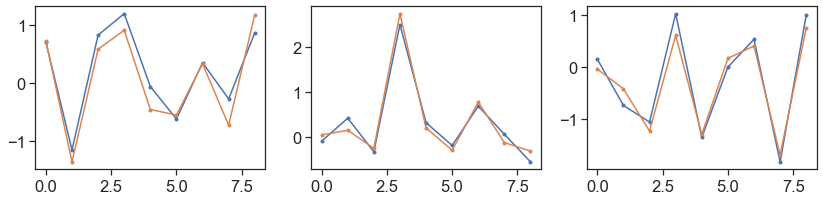

In [662]:
plt.figure(figsize=(14,3))

for i in range(dim):
    
    plt.subplot(1,dim,i+1)
    plt.plot((np.linalg.matrix_power(Ainf,1)@x)[:,i],marker='.')
    plt.plot((np.linalg.matrix_power(A,1)@x)[:,i],marker='.')
    #plt.

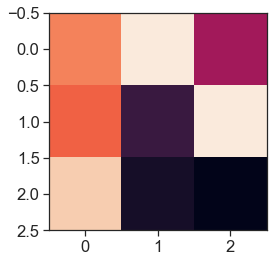

In [267]:
plt.imshow(Ainf)

DeviceArray([[-0.2401935 ,  0.02202098, -0.97047526],
             [ 0.96790737, -0.0706854 , -0.2411619 ],
             [-0.07390901, -0.99725556, -0.00433615]], dtype=float32)

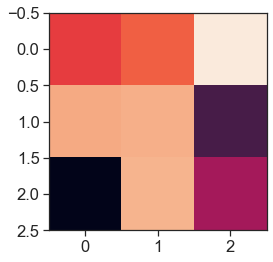

In [268]:
plt.imshow(A)

# Get this to work with cell activity with structured noise

In [684]:
n_neurons = 120
dim = 3
nT = 9

frac_noise_dynamics = .3

x0 = np.random.normal(size=(dim,1))
A_ = np.random.normal(size=(dim,dim))

A = np.zeros([dim,dim])

for i in range(dim):
    A[i,i:] = A_[i:,i]
    A[i:,i] = -A_[i:,i]
    
A[np.diag_indices_from(A)] = 0
A = (np.eye(dim)-A)@np.linalg.inv(np.eye(dim)+A)

x = np.array([np.linalg.matrix_power(A,i)@x0 for i in range(nT)])

x = frac_noise_dynamics*x #+ (1-frac_noise_dynamics)*np.random.normal(size=x.shape)


W = np.random.normal(size=(n_neurons,dim))
basis_tensor = get_basis_tensor(dim)
n_bases = basis_tensor.shape[0]

In [691]:
y = W@x[:,:,0].T